In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import cv2


Shape of images: (35887, 2304)
Shape of labels: (35887,)
Shape of normalized images: (35887, 48, 48, 1)


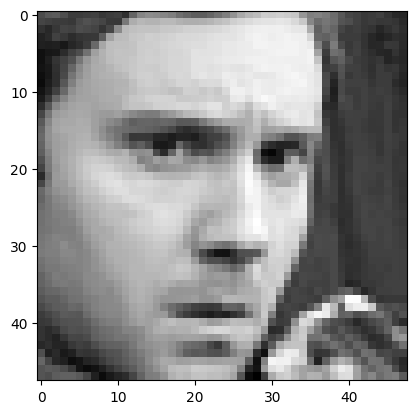

Shape of labels: (35887, 7)
Shapes: (28709, 48, 48, 1) (7178, 48, 48, 1) (28709, 7) (7178, 7)


In [2]:
# Load raw dataset
data = pd.read_csv('fer2013_2.csv')
images = np.array([np.fromstring(img, sep=' ') for img in data['pixels']])
labels = data['emotion'].values
print('Shape of images:', images.shape)
print('Shape of labels:', labels.shape)

# Reshape and normalize images
reshaped_images = np.zeros((images.shape[0], 48, 48, 1))
i = 0
for image in images:
    reshaped_images[i] = image.reshape((48, 48, 1))
    i += 1
norm_images = reshaped_images / 255.0
print('Shape of normalized images:', norm_images.shape)

# Display a sample image
plt.imshow(norm_images[0].reshape((48, 48)), cmap='gray')
plt.show()

# Convert labels to one-hot
new_labels = to_categorical(labels, num_classes=7)
print('Shape of labels:', new_labels.shape)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(norm_images, new_labels, test_size=0.2, random_state=42)
print('Shapes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [3]:
model = Sequential()
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

In [4]:
epochs = 30
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, mode='auto')
checkpoint = ModelCheckpoint('fer_model.h5', monitor='val_loss', mode='min', verbose=1)
callbacks = [checkpoint, reduce_lr]

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=callbacks, epochs=epochs)


Epoch 1/30
898/898 [==============================] - ETA: 0s - loss: 1.7203 - accuracy: 0.3368
Epoch 1: saving model to fer_model.h5


c:\Users\LAPSHOP\keras_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 1086s 1s/step - loss: 1.7203 - accuracy: 0.3368 - val_loss: 1.6617 - val_accuracy: 0.3640 - lr: 0.0010
Epoch 2/30
898/898 [==============================] - ETA: 0s - loss: 1.3538 - accuracy: 0.4789
Epoch 2: saving model to fer_model.h5
898/898 [==============================] - 891s 993ms/step - loss: 1.3538 - accuracy: 0.4789 - val_loss: 1.3590 - val_accuracy: 0.4752 - lr: 0.0010
Epoch 3/30
898/898 [==============================] - ETA: 0s - loss: 1.2387 - accuracy: 0.5269
Epoch 3: saving model to fer_model.h5
898/898 [==============================] - 890s 991ms/step - loss: 1.2387 - accuracy: 0.5269 - val_loss: 1.2246 - val_accuracy: 0.5191 - lr: 0.0010
Epoch 4/30
898/898 [==============================] - ETA: 0s - loss: 1.1703 - accuracy: 0.5576
Epoch 4: saving model to fer_model.h5
898/898 [==============================] - 893s 995ms/step - loss: 1.1703 - accuracy: 0.5576 - val_loss: 1.1564 - val_accuracy: 0.5603 - lr: 0.0010
Epoch 5/

In [5]:
test_true = np.argmax(y_test, axis=1)
test_pred = np.argmax(model.predict(X_test), axis=1)
print('CNN Model Accuracy on test set: {:.4f}'.format(accuracy_score(test_true, test_pred)))

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
print(classification_report(test_true, test_pred, target_names=emotion_labels))

225/225 [==============================] - 43s 191ms/step
CNN Model Accuracy on test set: 0.6548
              precision    recall  f1-score   support

       Angry       0.61      0.53      0.57       985
     Disgust       0.74      0.63      0.68       102
        Fear       0.57      0.39      0.47      1043
       Happy       0.84      0.85      0.85      1765
         Sad       0.50      0.59      0.54      1210
    Surprise       0.75      0.79      0.77       795
     Neutral       0.59      0.66      0.63      1278

    accuracy                           0.65      7178
   macro avg       0.66      0.64      0.64      7178
weighted avg       0.66      0.65      0.65      7178



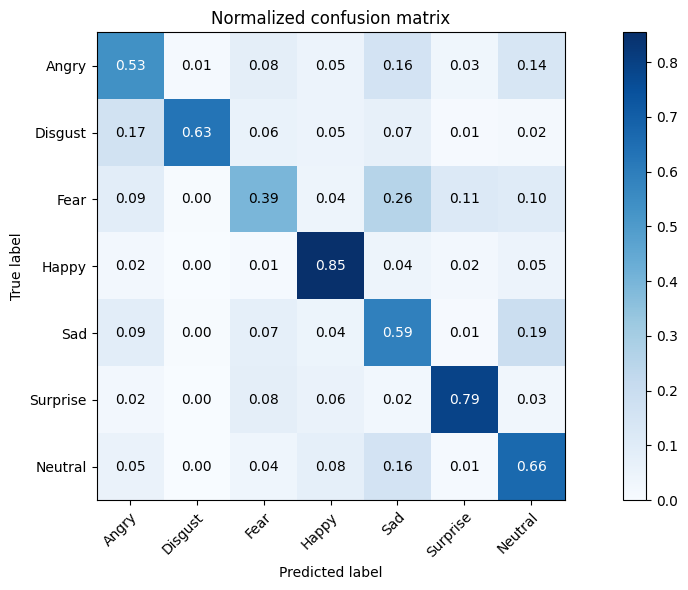

In [6]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes, title=title,
           ylabel='True label', xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha='center', va='center',
                    color='white' if cm[i, j] > thresh else 'black')
    fig.tight_layout()
    return ax

plot_confusion_matrix(test_true, test_pred, classes=emotion_labels, normalize=True, title='Normalized confusion matrix')
plt.show()

In [7]:
emotion_dict = {0: 'Angry', 1: 'Disgusted', 2: 'Fearful', 3: 'Happy', 4: 'Sad', 5: 'Surprised', 6: 'Neutral'}
emojis = {0: '\U0001f620', 1: '\U0001f922', 2: '\U0001f628', 3: '\U0001f60A', 4: '\U0001f625', 5: '\U0001f632', 6: '\U0001f610'}
print(emojis.values())

dict_values(['😠', '🤢', '😨', '😊', '😥', '😲', '😐'])


In [ ]:
def _predict(path):
    facecasc = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    imagePath = path
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=10)
    print('No of faces: ', len(faces))
    i = 1
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
        roi_gray = gray[y:y+h, x:x+w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        cropped_img = cropped_img / 255.0
        prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(prediction))
        print('person ', i, ' : ', emotion_dict[maxindex], '-->', emojis[maxindex])
        cv2.putText(image, emotion_dict[maxindex], (x+10, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        plt.show()
        i += 1

# Example usage (replace 'path_to_image.jpg' with your image path)


No of faces:  6
1/1 [==============================] - 0s 87ms/step
person  1  :  Fearful --> 😨


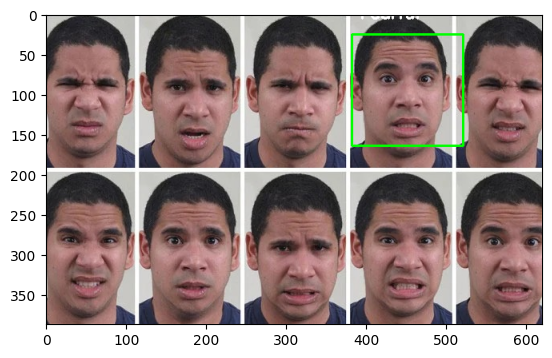

1/1 [==============================] - 0s 51ms/step
person  2  :  Fearful --> 😨


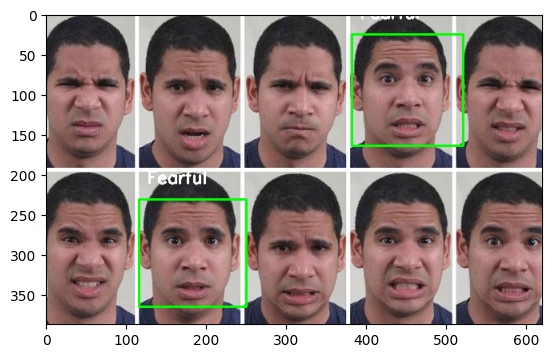

1/1 [==============================] - 0s 46ms/step
person  3  :  Fearful --> 😨


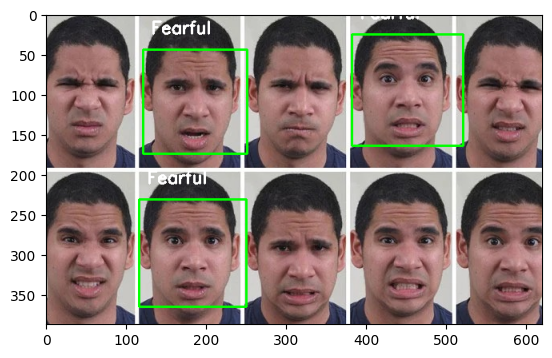

1/1 [==============================] - 0s 40ms/step
person  4  :  Angry --> 😠


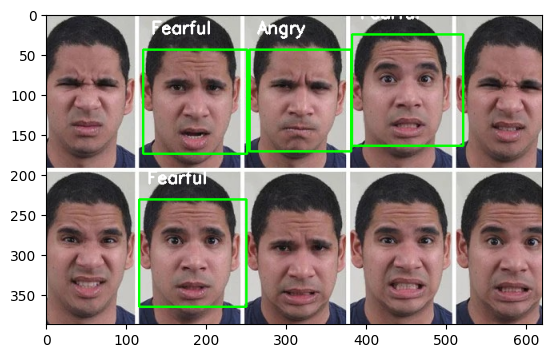

1/1 [==============================] - 0s 48ms/step
person  5  :  Fearful --> 😨


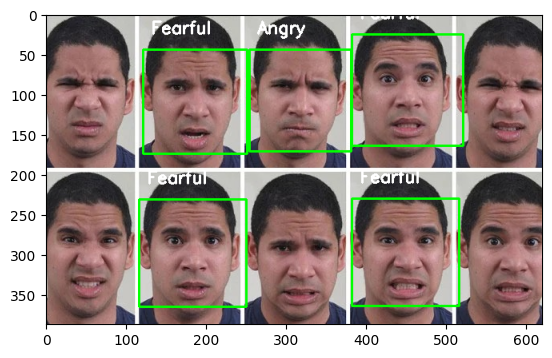

1/1 [==============================] - 0s 40ms/step
person  6  :  Sad --> 😥


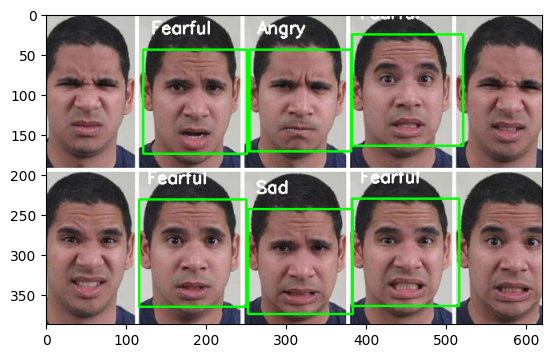

In [9]:
_predict('C:/Users/LAPSHOP/Desktop/finalproject/finalproject/ML/tenface.jpg')